In [1]:
import sys
sys.path.append("../")
from tuneavideo.pipelines.pipeline_tuneavideo import TuneAVideoPipeline
from tuneavideo.pipelines.pipeline_tuneavideo_video2video import TuneAVideoVideo2VideoPipeline
from tuneavideo.pipelines import pipeline_tuneavideo_video2video

from tuneavideo.models.unet import UNet3DConditionModel
from tuneavideo.util import save_videos_grid, read_gif, save_as_gif
import torch
from einops import rearrange
import einops
import decord
from matplotlib import pyplot as plt
from PIL import Image
from moviepy import editor
import numpy as np
decord.bridge.set_bridge('torch')

/mnt/disks/disk_main/anaconda3/envs/tune_a_video/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_id = "../outputs/tilting_head/2023-02-04T12-46-15"
model_id = "../checkpoints/tav_yor_dedede"
unet = UNet3DConditionModel.from_pretrained(model_id, subfolder='unet', torch_dtype=torch.float16).to('cuda')
pipe = TuneAVideoVideo2VideoPipeline.from_pretrained("../checkpoints/dedede", unet=unet, torch_dtype=torch.float16).to("cuda")
pipe.unet.enable_xformers_memory_efficient_attention()

The config attributes {'$comment': 'delete mid_block_type'} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [3]:
video = decord.VideoReader("../data/tilting_head/tilting_head.mp4")

In [29]:
posi = "high school white hair 1girl tilting her head, masterpiece, best quality, 8k, detailed anime style anime girl"
nega = "3d, flat shading, flat color, retro style, 1980s, 1990s, 2000s, 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry, artist name, inaccurate limb"
strength = 0.7
seed = 0
fps = 8

In [32]:
v = pipe(prompt=posi,negative_prompt=nega, video=video[:],strength=strength,height=512, width=512, num_inference_steps=50, guidance_scale=7.5, fix_seed_across_frames=False).videos
# save_videos_grid(v, f"../data/out/tmp.gif")

100%|██████████| 35/35 [01:42<00:00,  2.94s/it]


In [33]:
def to_np_video(x):
    x = x.squeeze(0)
    print(x.shape)
    x = rearrange(x, "c t h w -> t h w c")
    print(x.shape)
    x = (x * 255).numpy().astype(np.uint8)
    return x

v_np = to_np_video(v)
clip = editor.ImageSequenceClip(list(v_np), fps=8)
clip.ipython_display()

torch.Size([3, 16, 512, 512])
torch.Size([16, 512, 512, 3])
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [35]:
clip.write_videofile("../data/tilting_head/out/v2v_strength_07_white_hair.mp4")

Moviepy - Building video ../data/tilting_head/out/v2v_strength_07_white_hair.mp4.
Moviepy - Writing video ../data/tilting_head/out/v2v_strength_07_white_hair.mp4



Moviepy - Done !
Moviepy - video ready ../data/tilting_head/out/v2v_strength_07_white_hair.mp4


In [28]:
t = torch.randn(1, 3, 30, 30)
einops.repeat(t, "b c h w -> b c f h w", f=10).shape

torch.Size([1, 3, 10, 30, 30])

In [65]:
images = [Image.fromarray(image.numpy()) for image in video]
save_as_gif(images, "../data/yor_short.gif", duration=330)

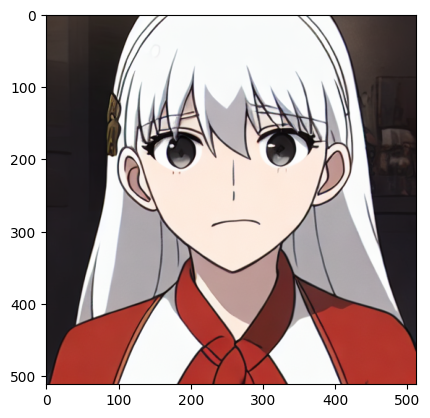

In [29]:
v = video[0]
v = rearrange(v, "c f h w -> f h w c")
plt.imshow(v[3].cpu().numpy())

In [73]:
torch.cuda.empty_cache()

In [8]:
pipe.scheduler.num_inference_steps

In [13]:
num_inference_steps = 50
strength = 0.5

pipe.scheduler.set_timesteps(num_inference_steps, device=pipe.device)

def prepare_init_latent(pipe, video_path, index_list:list, strength):
    vr = decord.VideoReader("../data/yor.mp4", width=512, height=512)
    video = vr.get_batch(index_list)
    video = rearrange(video, "b h w c -> b c h w")
    video = video.to(pipe.device).half()
    latent = pipe.vae.encode(video).latent_dist.sample()
    latent = 0.18215 * latent
    noise = torch.randn(latent.shape, device=pipe.device, dtype=torch.float16)

    init_timestep = int(pipe.scheduler.num_inference_steps * strength)
    t_start = pipe.scheduler.num_inference_steps - init_timestep
    timesteps = pipe.scheduler.timesteps[t_start:]

    latent = pipe.scheduler.add_noise(latent, noise, timesteps[:1])
    print(latent.shape)
    
prepare_init_latent(pipe, "../data/yor.mp4", [0, 1, 2, 3,4], 0.5)


RuntimeError: CUDA out of memory. Tried to allocate 320.00 MiB (GPU 0; 14.76 GiB total capacity; 13.49 GiB already allocated; 217.75 MiB free; 13.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [58]:
# TODO: This code may degrade image quality
def read_gif(path) -> list[Image.Image]:
    gif_image = Image.open(path)
    images = []
    for index in range(gif_image.n_frames):
        gif_image.seek(index)
        images.append(gif_image.copy().convert("RGB"))

    return images

# TODO: This code may degrade image quality
def save_as_gif(images: list[Image.Image], path, duration=500, loop=0):
    images[0].save(path, save_all=True, append_images=images[1:], duration=duration, loop=loop)
